In [198]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score as r2
from sklearn.model_selection import cross_val_score


In [199]:
train_data_path = 'data/train.csv'
prepared_data_path = 'data/train_prep.csv'
target = 'Price'

In [200]:
df = pd.read_csv(train_data_path, header=0)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


## Разведочный анализ

### Изучение целевой переменной

In [201]:
plt.style.use('fivethirtyeight')

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Видим много пропусков в LifeSquare и в HealthCare, несколько категориальных призаков

In [203]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [204]:
target_mean = round(df[target].mean(), 2)
target_median = round(df[target].median(), 2)

target_mean, target_median

(214138.86, 192269.64)

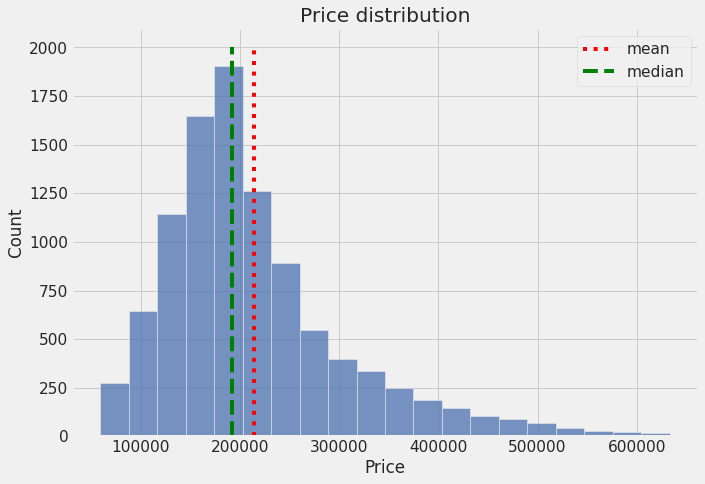

In [205]:
plt.figure(figsize=(10, 7))

y = np.linspace(0, 2000, 10)
sns.histplot(df['Price'], bins=20)


plt.plot([target_mean] * 10, y, label='mean', color='red', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', color='green', linestyle='--', linewidth=4)


plt.xlabel('Price')
plt.ylabel('Count')

plt.title('Price distribution')
plt.legend()

plt.show()

Данные распределены равномерно, выбросов не видно
- Медианная цена - 192269$, 
- Средняя цена дома в датасете - 214138$

### Распределения признаков

Посмотрим на heatmap

In [206]:
df_num_features = df.select_dtypes(include=['int64', 'float64'])

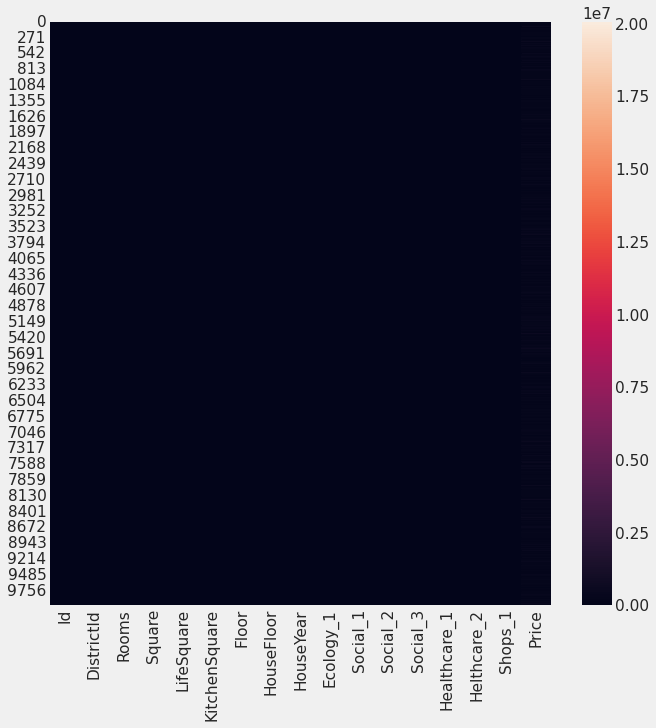

In [207]:
plt.figure(figsize=(10, 10))

sns.heatmap(df_num_features)

Посмотрим на выбросы 

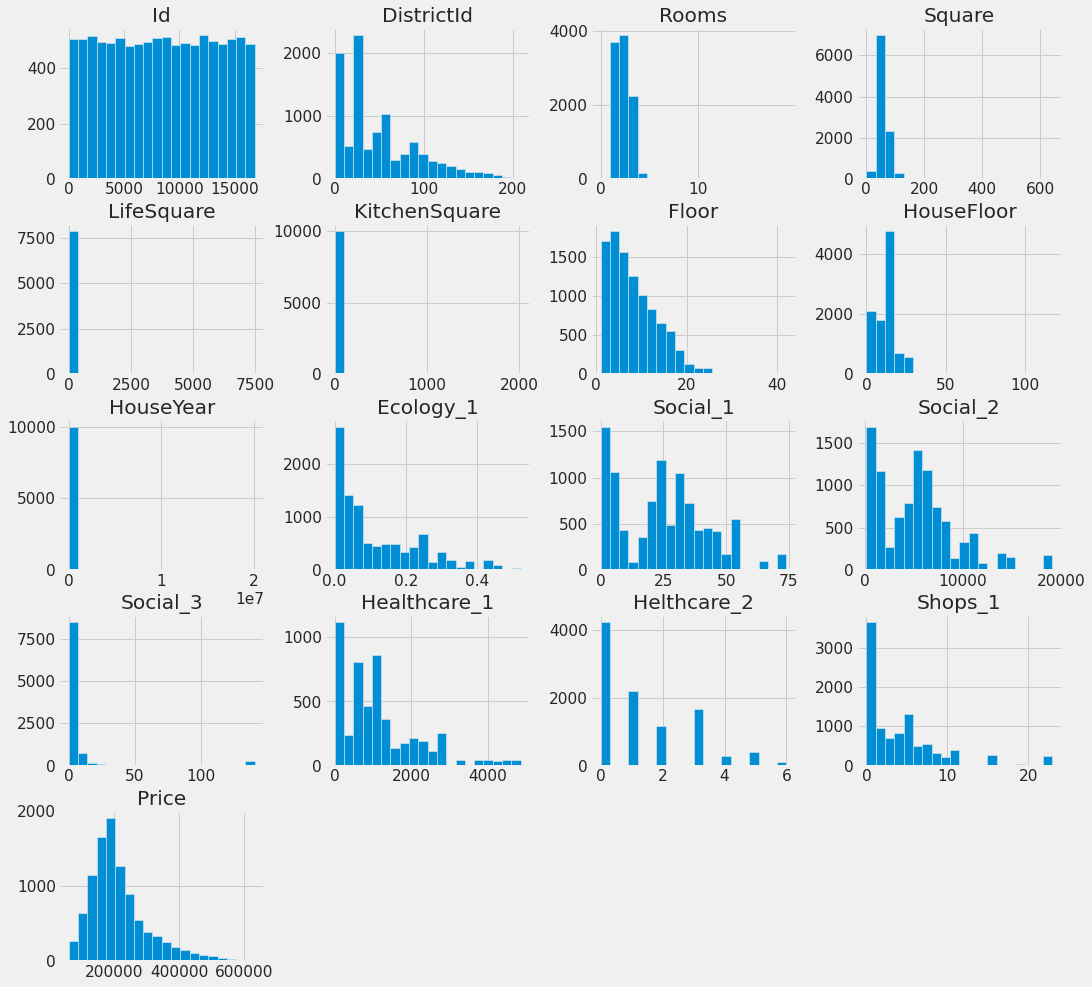

In [208]:
df_num_features.hist(bins=20, figsize=(16, 16))
plt.show()

Видим, что в признаках Rooms, Square, LifeSquare, KitchenSquare, HouseFloor, HouseYear скорее всего присутствуют выбросы

Посмотрим на них детальнее

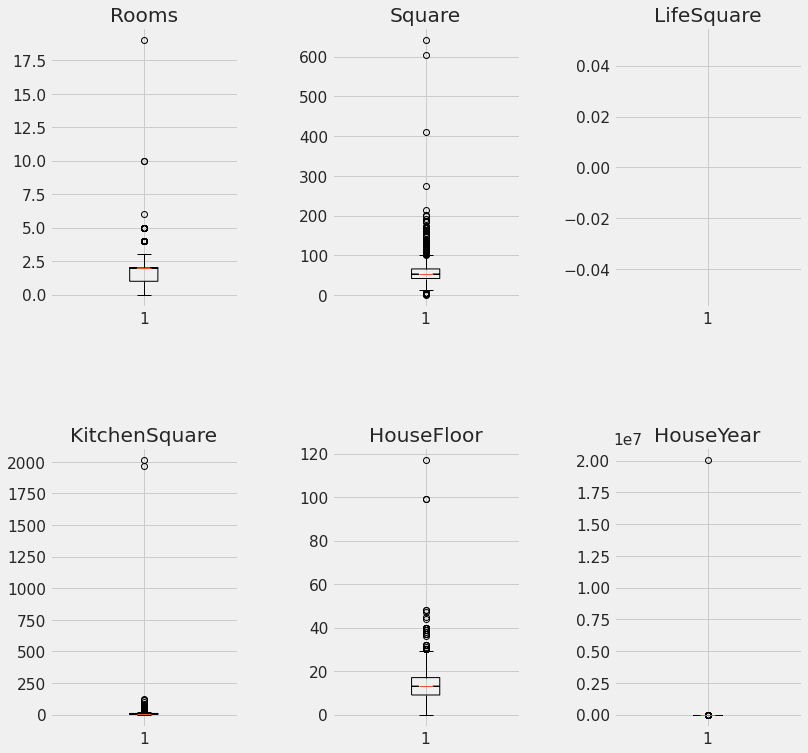

In [209]:
fig, ax = plt.subplots(nrows=2, ncols=3)
ax1, ax2, ax3, ax4, ax5, ax6 = ax.flatten()

ax1.boxplot(df['Rooms'], ['Rooms'])
ax1.set_title('Rooms')

ax2.boxplot(df['Square'], ['Square'])
ax2.set_title('Square')

ax3.boxplot(df['LifeSquare'], ['LifeSquare'])
ax3.set_title('LifeSquare')

ax4.boxplot(df['KitchenSquare'], ['KitchenSquare'])
ax4.set_title('KitchenSquare')

ax5.boxplot(df['HouseFloor'], ['HouseFloor'])
ax5.set_title('HouseFloor')

ax6.boxplot(df['HouseYear'], ['HouseYear'])
ax6.set_title('HouseYear')

fig.set_size_inches(12, 12)
plt.subplots_adjust(hspace=0.5, wspace=0.5)

Почистим их от выбросов, затем заполним LifeSquare

In [210]:
df.loc[df['Rooms']>=10, 'Rooms'] = df['Rooms'].median()
df.loc[df['Rooms'] == 0.0, 'Rooms'] = df['Rooms'].median()
df['Rooms'].value_counts()

2.0    3891
1.0    3705
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

In [211]:
df.loc[df['Square']>=200, 'Square'] = df['Square'].median()

In [212]:
df.loc[df['KitchenSquare']>=50, 'KitchenSquare'] = df['KitchenSquare'].median()
df.loc[df['KitchenSquare']==0, 'KitchenSquare']  = df['KitchenSquare'].median()

In [213]:
# Удалим из выборки квартиры, этаж которых больше 50
df = df[df['HouseFloor'] <= 50]
df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['HouseFloor'].median()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [214]:
df = df[df['HouseYear'] <= 2022]
df.loc[df['HouseYear'] < 1500, 'HouseYear'] = df['HouseYear'].median()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [215]:
# Заполним пустые поля LifeSquare значением Square - KitchenSquare
df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = df[df['LifeSquare'].isna()]['Square'] - df[df['LifeSquare'].isna()]['KitchenSquare']
df.loc[df['LifeSquare']>=100, 'LifeSquare'] = df.loc[df['LifeSquare']>=100, 'Square'] - df.loc[df['LifeSquare']>=100, 'KitchenSquare']
df.loc[df['LifeSquare']==0, 'LifeSquare'] = df.loc[df['LifeSquare']==0, 'Square'] - df.loc[df['LifeSquare']==0, 'KitchenSquare']

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [216]:
df.loc[df['LifeSquare']>=100, 'LifeSquare'] = df['LifeSquare'].median()
df.loc[df['LifeSquare']==0.0, 'LifeSquare'] = df['LifeSquare'].median()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [217]:
df.loc[df['Ecology_2'].isna(), 'Ecology_2'] = df['Ecology_2'].mode()
df.loc[df['Ecology_3'].isna(), 'Ecology_3'] = df['Ecology_3'].mode()
df.loc[df['Shops_2'].isna(), 'Shops_2'] = df['Shops_2'].mode()


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1797: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, v, pi)


In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9995 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             9995 non-null   int64  
 1   DistrictId     9995 non-null   int64  
 2   Rooms          9995 non-null   float64
 3   Square         9995 non-null   float64
 4   LifeSquare     9995 non-null   float64
 5   KitchenSquare  9995 non-null   float64
 6   Floor          9995 non-null   int64  
 7   HouseFloor     9995 non-null   float64
 8   HouseYear      9995 non-null   int64  
 9   Ecology_1      9995 non-null   float64
 10  Ecology_2      9995 non-null   object 
 11  Ecology_3      9995 non-null   object 
 12  Social_1       9995 non-null   int64  
 13  Social_2       9995 non-null   int64  
 14  Social_3       9995 non-null   int64  
 15  Healthcare_1   5198 non-null   float64
 16  Helthcare_2    9995 non-null   int64  
 17  Shops_1        9995 non-null   int64  
 18  Shops_2 

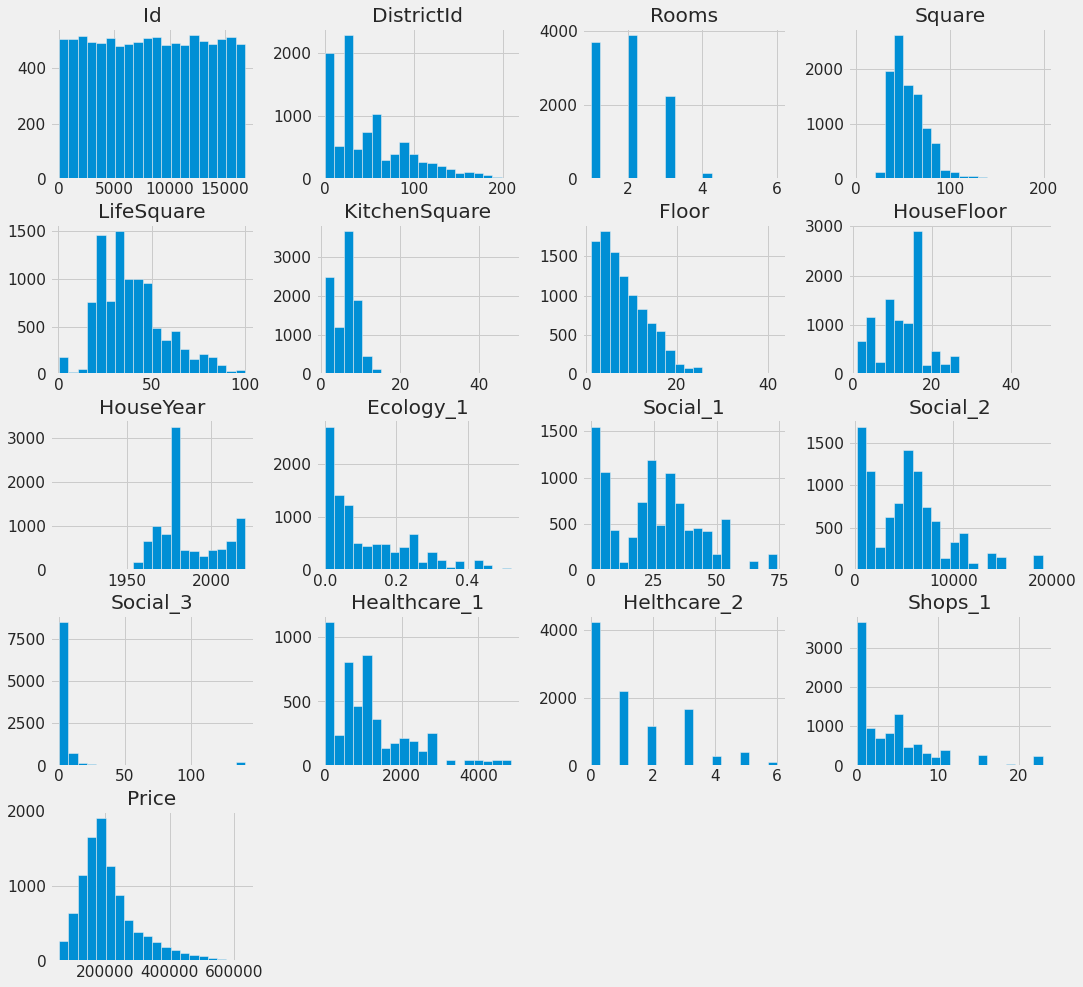

In [219]:
df_num_features = df.select_dtypes(include=['int64', 'float64'])
df_num_features.hist(bins=20, figsize=(16, 16))
plt.show()

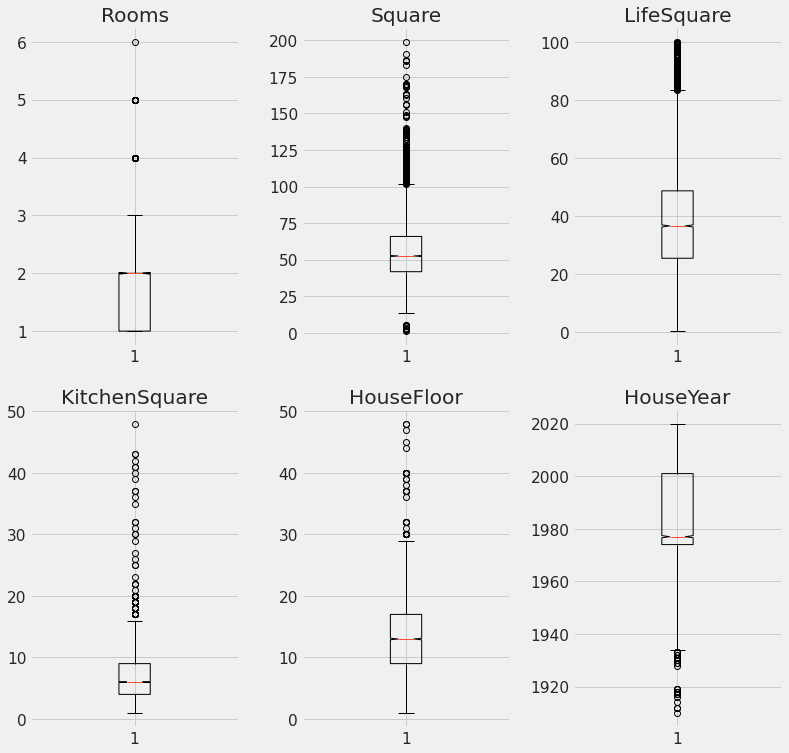

In [220]:
fig, ax = plt.subplots(nrows=2, ncols=3)
ax1, ax2, ax3, ax4, ax5, ax6 = ax.flatten()

ax1.boxplot(df['Rooms'], ['Rooms'])
ax1.set_title('Rooms')

ax2.boxplot(df['Square'], ['Square'])
ax2.set_title('Square')

ax3.boxplot(df['LifeSquare'], ['LifeSquare'])
ax3.set_title('LifeSquare')

ax4.boxplot(df['KitchenSquare'], ['KitchenSquare'])
ax4.set_title('KitchenSquare')

ax5.boxplot(df['HouseFloor'], ['HouseFloor'])
ax5.set_title('HouseFloor')

ax6.boxplot(df['HouseYear'], ['HouseYear'])
ax6.set_title('HouseYear')

fig.set_size_inches(12, 12)
plt.subplots_adjust(hspace=0.2, wspace=0.3)

В графе Healthcare_1 слишком много пропусков, посмотрим, какая корреляция у этого признака с ценой

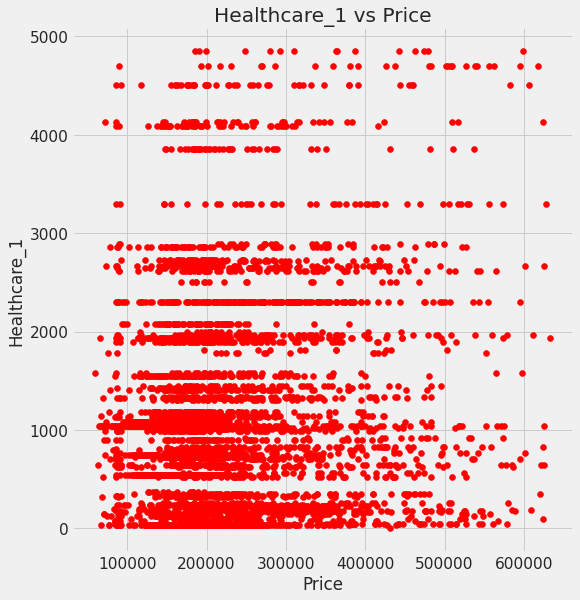

In [221]:
plt.figure(figsize=(8, 9))
plt.scatter(df[target], df['Healthcare_1'], color='red')
plt.xlabel('Price')
plt.ylabel('Healthcare_1')
plt.title('Healthcare_1 vs Price')
plt.show()

прямой зависимости у признака нет, поэтому удалим его

In [222]:
df = df.drop(['Healthcare_1'], axis=1)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,B,B,34,7759,0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2,4,B,150226.531644


id и DistrictId на цену не влияют, их тоже удалим

In [223]:
df = df.drop(['Id', 'DistrictId'], axis=1)
df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,0,11,B,184966.930730
1,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,1,16,B,300009.450063
2,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,B,B,34,7759,0,1,3,B,220925.908524
3,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,0,5,B,175616.227217
4,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2,4,B,150226.531644


Посмотрим, можно ли разбить недвижимость на классы по площади

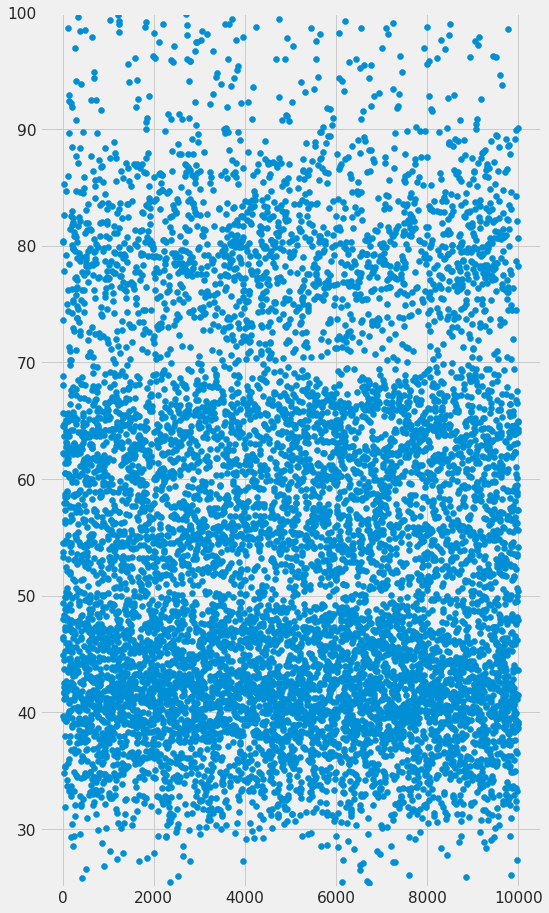

In [224]:
plt.figure(figsize=(8, 15))

plt.scatter(df.index, df['Square'])
plt.ylim([25, 100])
plt.show()

Видим, что по площади жильё можно разбить на 3 кластера, добавим новый признак

**Матрица корреляций**

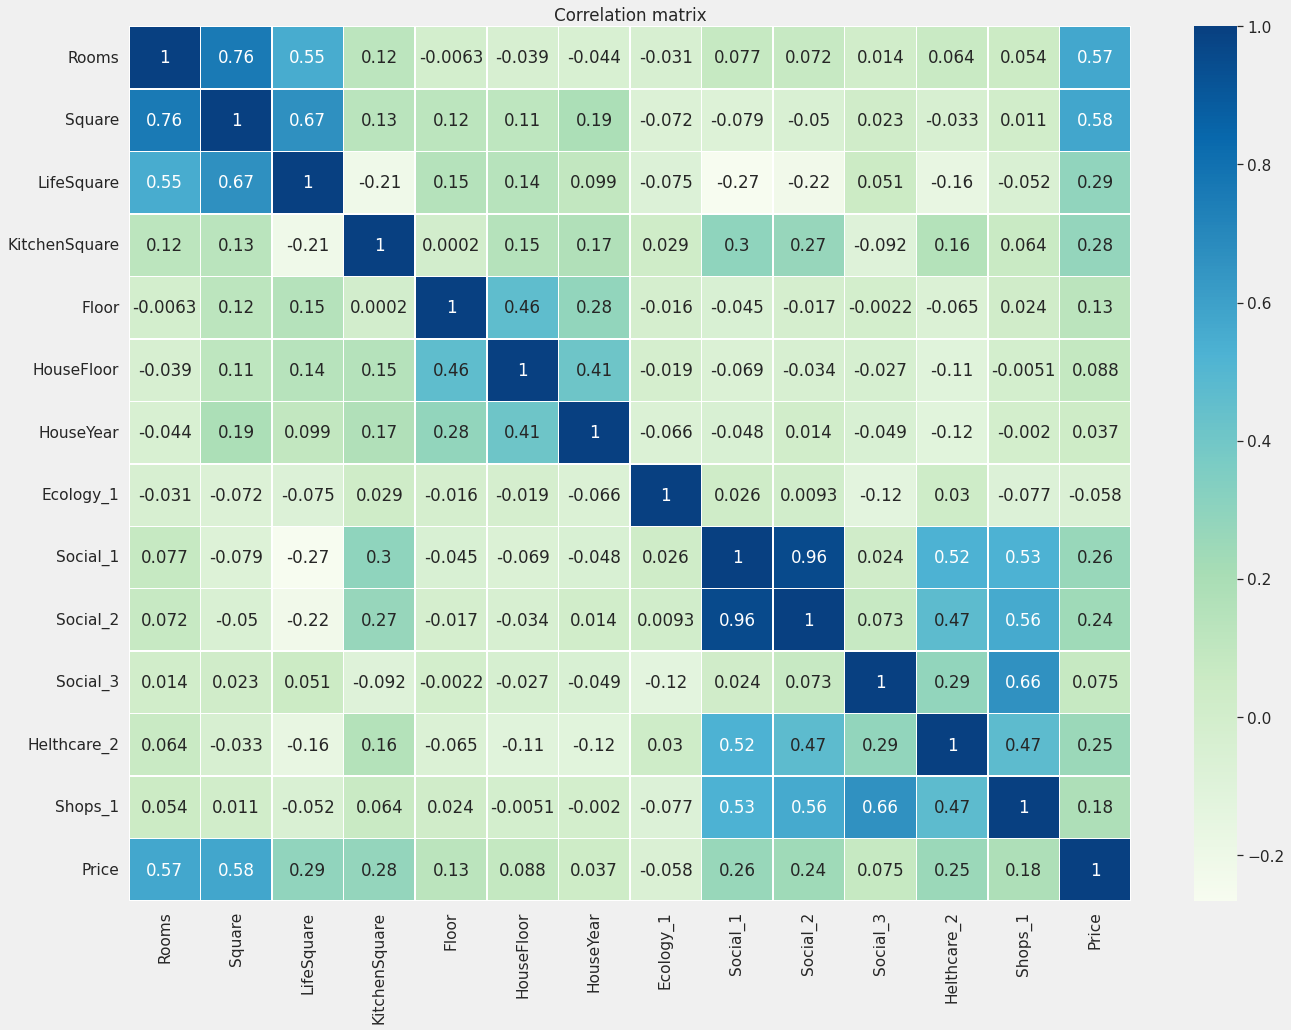

In [225]:
plt.figure(figsize=(20, 15))

sns.set(font_scale=1.4)
sns.heatmap(df.corr(), annot=True, linewidth=.5, cmap='GnBu') 

plt.title('Correlation matrix')
plt.show()

### Приведение типов данных и добавление признаков

In [226]:
df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,0,11,B,184966.930730
1,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,1,16,B,300009.450063
2,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,B,B,34,7759,0,1,3,B,220925.908524
3,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,0,5,B,175616.227217
4,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2,4,B,150226.531644


Судя по распределениям, Ecology_2, Ecolody_3, Helthcare_2, Shops_2 являются категориальными признаками. Посмотрим на категории:

In [227]:
df['Ecology_2'].value_counts()

B    9898
A      97
Name: Ecology_2, dtype: int64

In [228]:
df['Ecology_3'].value_counts()

B    9720
A     275
Name: Ecology_3, dtype: int64

In [229]:
df['Helthcare_2'].value_counts()

0    4213
1    2183
3    1668
2    1158
5     387
4     287
6      99
Name: Helthcare_2, dtype: int64

In [230]:
df['Shops_2'].value_counts()

B    9170
A     825
Name: Shops_2, dtype: int64

Пусть в тех признаках, где 2 категории, А будет 1, а В - 0

In [231]:
df.loc[df['Ecology_2']=='A', 'Ecology_2'] = 1
df.loc[df['Ecology_2']=='B', 'Ecology_2'] = 0
df['Ecology_2'].value_counts()

0    9898
1      97
Name: Ecology_2, dtype: int64

In [232]:
df.loc[df['Ecology_3']=='A', 'Ecology_3'] = 1
df.loc[df['Ecology_3']=='B', 'Ecology_3'] = 0

df.loc[df['Shops_2']=='A', 'Shops_2'] = 1
df.loc[df['Shops_2']=='B', 'Shops_2'] = 0
df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,0,0,33,7976,5,0,11,0,184966.930730
1,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,0,0,46,10309,1,1,16,0,300009.450063
2,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,0,0,34,7759,0,1,3,0,220925.908524
3,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,0,0,23,5735,3,0,5,0,175616.227217
4,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,0,0,35,5776,1,2,4,0,150226.531644


из Helthcare_2 6 dummie признаков

In [233]:
df['Ecology_2'] = df['Ecology_2'].astype(np.int64)
df['Ecology_3'] = df['Ecology_3'].astype(np.int64)
df['Shops_2'] = df['Shops_2'].astype(np.int64)
df['Helthcare_2'] = df['Helthcare_2'].astype(np.int64)

Так как признаки Square, LifeSquare и KitchenSquare сильно коррелируют, оставим только параметр Square. При этом, чтобы не потерять смысл признаков LifeSquare и KitchenSquare, добавим новый признак: коэфициент, показывающий отношение жилой площади к площади кухни.

$$LifePart = LifeSquare / KitchenSquare$$

In [234]:
df['LifePart'] = df['LifeSquare']/df['KitchenSquare']
df = df.drop(['LifeSquare', 'KitchenSquare'], axis=1)
df.head()

,Rooms,Square,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifePart
0,2.0,47.981561,7,9.0,1969,0.089040,0,0,33,7976,5,0,11,0,184966.930730,4.907125
1,3.0,65.683640,7,9.0,1978,0.000070,0,0,46,10309,1,1,16,0,300009.450063,5.006193
2,2.0,44.947953,8,12.0,1968,0.049637,0,0,34,7759,0,1,3,0,220925.908524,4.866269
3,2.0,53.352981,8,17.0,1977,0.437885,0,0,23,5735,3,0,5,0,175616.227217,5.859057
4,1.0,39.649192,11,12.0,1976,0.012339,0,0,35,5776,1,2,4,0,150226.531644,3.396596


Разобьём жилье по кластерам в зависимости от площади. Для этого применим алгоритм Kmeans, но прежде отмасштабируем данные с помощью MinMaxScaler

Чтобы не масштабировать исходные данные, создадим копию.

In [235]:
data = df['Square'].copy()

In [236]:
scaler = MinMaxScaler()

In [237]:
data = data.values.reshape(-1, 1)
data = scaler.fit_transform(data)

In [238]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=3, random_state=21)

In [239]:
ress = model.fit_predict(data)
ress

array([2, 0, 2, ..., 2, 2, 2], dtype=int32)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


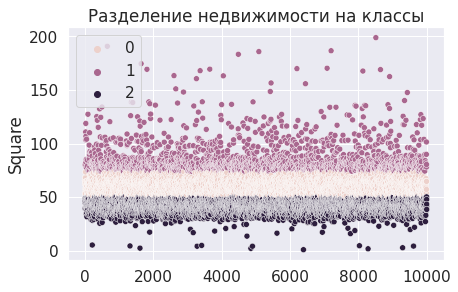

In [240]:
sns.scatterplot(df.index, df['Square'], hue=ress)
plt.title('Разделение недвижимости на классы')

plt.show()

Видим, что модель Kmeans довольно хорошо разделила наши данные на три категории. Посмотрим поближе на места разделения 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


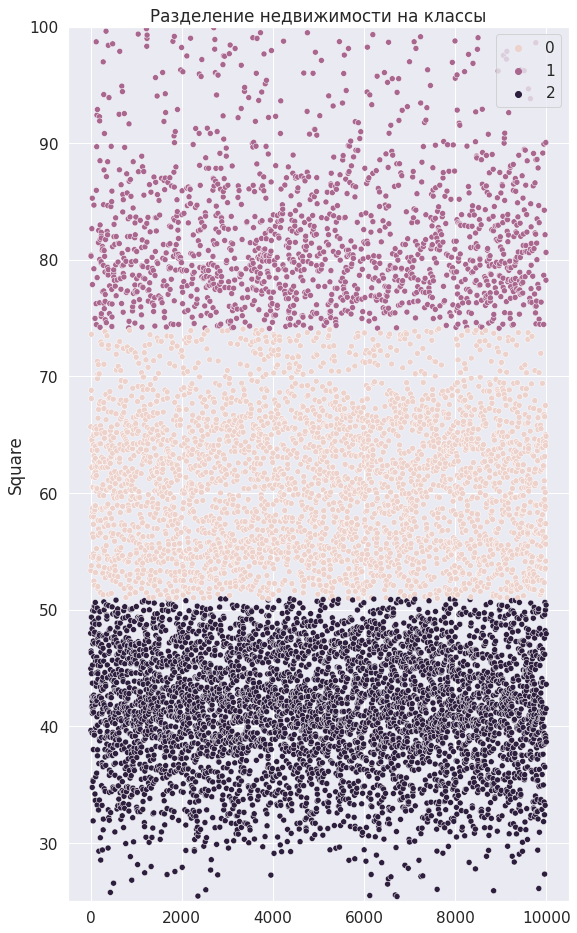

In [241]:
plt.figure(figsize=(8, 15))
sns.scatterplot(df.index, df['Square'], hue=ress)
plt.title('Разделение недвижимости на классы')
plt.ylim([25, 100])

plt.show()

Добавим классы как новый признак

In [242]:
df['Square_type'] = pd.Series(ress, dtype='category')
df.head()

,Rooms,Square,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifePart,Square_type
0,2.0,47.981561,7,9.0,1969,0.089040,0,0,33,7976,5,0,11,0,184966.930730,4.907125,2
1,3.0,65.683640,7,9.0,1978,0.000070,0,0,46,10309,1,1,16,0,300009.450063,5.006193,0
2,2.0,44.947953,8,12.0,1968,0.049637,0,0,34,7759,0,1,3,0,220925.908524,4.866269,2
3,2.0,53.352981,8,17.0,1977,0.437885,0,0,23,5735,3,0,5,0,175616.227217,5.859057,0
4,1.0,39.649192,11,12.0,1976,0.012339,0,0,35,5776,1,2,4,0,150226.531644,3.396596,2


In [243]:
df = pd.get_dummies(df)
df.head()

,Rooms,Square,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifePart,Square_type_0,Square_type_1,Square_type_2
0,2.0,47.981561,7,9.0,1969,0.089040,0,0,33,7976,5,0,11,0,184966.930730,4.907125,0,0,1
1,3.0,65.683640,7,9.0,1978,0.000070,0,0,46,10309,1,1,16,0,300009.450063,5.006193,1,0,0
2,2.0,44.947953,8,12.0,1968,0.049637,0,0,34,7759,0,1,3,0,220925.908524,4.866269,0,0,1
3,2.0,53.352981,8,17.0,1977,0.437885,0,0,23,5735,3,0,5,0,175616.227217,5.859057,1,0,0
4,1.0,39.649192,11,12.0,1976,0.012339,0,0,35,5776,1,2,4,0,150226.531644,3.396596,0,0,1


Почистим от повторов строк

In [244]:
df.drop_duplicates(inplace=True)

Сохраним подготовленные данные в файл

In [245]:
df.to_csv(prepared_data_path, index=False, encoding='utf-8')

### Построение модели 

Перед построением, я проверил данные на всех моделях, изучавшихся в рамках курса. По итогу лучший результат на стандартных параметрах показали: 
- RandomForestRegressor
- XGBRegressor
- SVR

Случайный лес показал наилучший результат, поэтому построим предсказание на его основе.

Для оценки качества модели будем использовать функцию evaluate_preds 

In [246]:
def evaluate_preds(true_values, pred_values):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 4)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 4)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 4))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 600000], [0, 600000], linestyle='--', color='black')
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')

    plt.show()

Для начала разобьем датасет на тренировочный и тестовый, а затем отмасштабируем с помощью StandartScaler (не обязательно для алгоритмов на основе деревьев решений)

In [247]:
df = pd.read_csv(prepared_data_path, header=0)
df.head()

,Rooms,Square,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifePart,Square_type_0,Square_type_1,Square_type_2
0,2.0,47.981561,7,9.0,1969,0.089040,0,0,33,7976,5,0,11,0,184966.930730,4.907125,0,0,1
1,3.0,65.683640,7,9.0,1978,0.000070,0,0,46,10309,1,1,16,0,300009.450063,5.006193,1,0,0
2,2.0,44.947953,8,12.0,1968,0.049637,0,0,34,7759,0,1,3,0,220925.908524,4.866269,0,0,1
3,2.0,53.352981,8,17.0,1977,0.437885,0,0,23,5735,3,0,5,0,175616.227217,5.859057,1,0,0
4,1.0,39.649192,11,12.0,1976,0.012339,0,0,35,5776,1,2,4,0,150226.531644,3.396596,0,0,1


In [248]:
x = df.drop(['Price'], axis=1)
y = df['Price']
x.head()

,Rooms,Square,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,LifePart,Square_type_0,Square_type_1,Square_type_2
0,2.0,47.981561,7,9.0,1969,0.089040,0,0,33,7976,5,0,11,0,4.907125,0,0,1
1,3.0,65.683640,7,9.0,1978,0.000070,0,0,46,10309,1,1,16,0,5.006193,1,0,0
2,2.0,44.947953,8,12.0,1968,0.049637,0,0,34,7759,0,1,3,0,4.866269,0,0,1
3,2.0,53.352981,8,17.0,1977,0.437885,0,0,23,5735,3,0,5,0,5.859057,1,0,0
4,1.0,39.649192,11,12.0,1976,0.012339,0,0,35,5776,1,2,4,0,3.396596,0,0,1


In [249]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=21)

In [250]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

С помощью GridSearchCV подберём наилучшие гиперпараметры для нашей модели 

In [251]:
# params = [{
#     'max_depth': np.arange(2, 19),
#     'max_features': np.arange(3, 15),
#     'n_estimators': np.arange(10, 1010, 200)
# }]


# rf = GridSearchCV(
#     estimator=RandomForestRegressor(random_state=21),
#     param_grid=params,
#     scoring='r2',
#     cv=3
# )

In [252]:
# rf.fit(x_train, y_train)

In [253]:
# rf.best_params_

Подобрали параметры, оценим точность модели на наших данных

In [254]:
rf = RandomForestRegressor(max_depth=18, max_features=4, n_estimators=810)

In [255]:
rf.fit(x_train, y_train)

RandomForestRegressor(max_depth=18, max_features=4, n_estimators=810)

R2:	0.7407
MAE:	29053.6638
MSE:	2309668391.6932


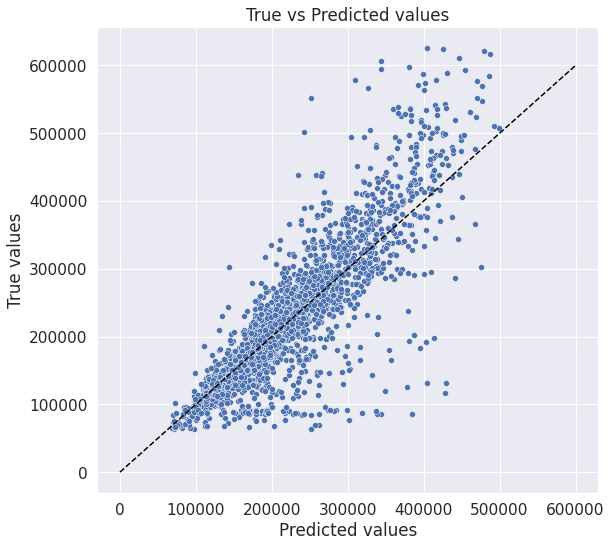

In [256]:
y_pred = rf.predict(x_test)
evaluate_preds(y_test, y_pred)

Посмотрим на валидность наших признаков

Для этого воспользуемся таким методом: 
- По очереди перемешаем значения в каждом столбце и попробуем построить модель на этих данных
- Посчитаем разность между r2 базовой модели и получившимся r2
- Примем полученные значения как вес признака
- Отберём бесполезные признаки и построим модель без них.

In [257]:
base_r2 = r2(y_test, y_pred)
base_r2

0.7406909213042283

In [258]:
def feature_weight_check(model, data):
  y = data['Price']
  for column in data.drop(['Price'], axis=1):
    df = data.copy()
    df[column] = df[column].sample(frac=1).reset_index(drop=True)
    x = df.drop(['Price'], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2022)
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f'{column}:\t {base_r2 - r2(y_test, y_pred)}, R2: {r2(y_test, y_pred)}\n')

In [259]:
# feature_weight_check(rf, df)

Rooms:	 0.002512068038610815, R2: 0.7370821144025745

Square:	 0.049469263677851094, R2: 0.6901249187633343

Floor:	 0.006130162877458378, R2: 0.733464019563727

HouseFloor:	 0.006737443191402681, R2: 0.7328567392497827

HouseYear:	 0.014232248779561862, R2: 0.7253619336616235

Ecology_1:	 0.012378154821635956, R2: 0.7272160276195494

Ecology_2:	 0.0013607768067949166, R2: 0.7382334056343904

Ecology_3:	 0.000920686370915913, R2: 0.7386734960702694

Social_1:	 0.003727533133497829, R2: 0.7358666493076875

Social_2:	 0.003488069494951951, R2: 0.7361061129462334

Social_3:	 0.01885609673901767, R2: 0.7207380857021677

Helthcare_2:	 0.0030495636699559014, R2: 0.7365446187712295

Shops_1:	 0.0035336063824533692, R2: 0.736060576058732

Shops_2:	 0.00299193786529528, R2: 0.7366022445758901

LifePart:	 0.0069419126554792765, R2: 0.7326522697857061

Square_type_0:	 0.0011508142210754357, R2: 0.7384433682201099

Square_type_1:	 0.0015893468956535983, R2: 0.7380048355455318

Square_type_2:	 0.0014575600477977346, R2: 0.7381366223933876

Видим, что признаки Ecology_3 и square_type_0 играют малую роль в точности предсказания модели, попробуем построить без них 

In [260]:
x = x.drop(['Ecology_3', 'Square_type_0'], axis=1)
x.head()

,Rooms,Square,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,LifePart,Square_type_1,Square_type_2
0,2.0,47.981561,7,9.0,1969,0.089040,0,33,7976,5,0,11,0,4.907125,0,1
1,3.0,65.683640,7,9.0,1978,0.000070,0,46,10309,1,1,16,0,5.006193,0,0
2,2.0,44.947953,8,12.0,1968,0.049637,0,34,7759,0,1,3,0,4.866269,0,1
3,2.0,53.352981,8,17.0,1977,0.437885,0,23,5735,3,0,5,0,5.859057,0,0
4,1.0,39.649192,11,12.0,1976,0.012339,0,35,5776,1,2,4,0,3.396596,0,1


In [261]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=21)

In [262]:
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [263]:
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

R2:	0.7426
MAE:	28834.9793
MSE:	2292364912.6698


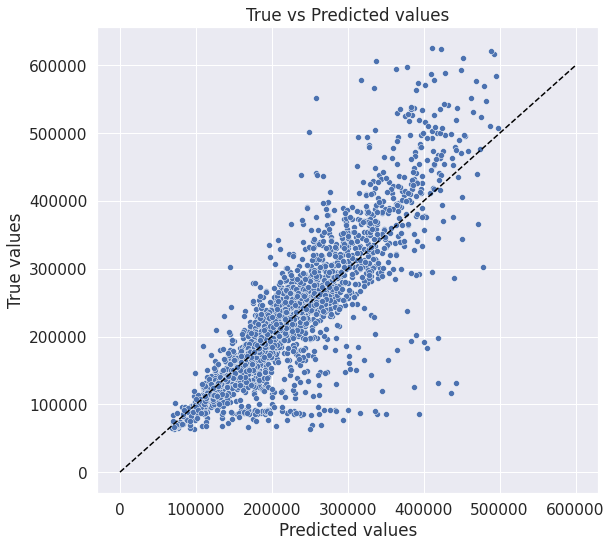

In [264]:
evaluate_preds(y_test, y_pred)

Теперь посмотрим на зависимость точности модели от размера обучающего датасета

In [265]:
# size = [2000, 4000, 6000, 7000, 8000, 9000]
# perc = [0.8, 0.6, 0.4, 0.3, 0.2, 0.1]

In [266]:
# result = []

# for i in perc:
#   x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=i, random_state=21)
#   rf.fit(x_train, y_train)
#   y_pred = rf.predict(x_test)
#   result.append(r2(y_test, y_pred))

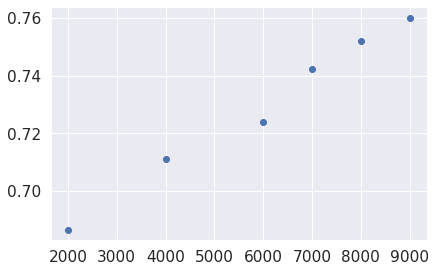

In [267]:
# size = np.array(size)
# result = np.array(result)

# plt.scatter(x=size, y=result)
# plt.show()

Видим линейную зависимость, обучим модель на всём наборе данных

Для простоты предобработки данных, обернём все операции над тестовыми данными для предсказания в функцию

In [268]:
def data_prep(df: pd.DataFrame):
    df.loc[df['Rooms']>=10, 'Rooms'] = df['Rooms'].median()
    df.loc[df['Rooms'] == 0.0, 'Rooms'] = df['Rooms'].median()
    df.loc[df['Square']>=200, 'Square'] = df['Square'].median()
    df.loc[df['KitchenSquare']>=50, 'KitchenSquare'] = df['KitchenSquare'].median()
    df.loc[df['KitchenSquare']==0, 'KitchenSquare']  = df['KitchenSquare'].median()
    df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['HouseFloor'].median()
    df.loc[df['HouseYear'] < 1500, 'HouseYear'] = df['HouseYear'].median()
    df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = df[df['LifeSquare'].isna()]['Square'] - df[df['LifeSquare'].isna()]['KitchenSquare']
    df.loc[df['LifeSquare']>=100, 'LifeSquare'] = df.loc[df['LifeSquare']>=100, 'Square'] - df.loc[df['LifeSquare']>=100, 'KitchenSquare']
    df.loc[df['LifeSquare']==0, 'LifeSquare'] = df.loc[df['LifeSquare']==0, 'Square'] - df.loc[df['LifeSquare']==0, 'KitchenSquare']
    df.loc[df['LifeSquare']>=100, 'LifeSquare'] = df['LifeSquare'].median()
    df.loc[df['LifeSquare']==0.0, 'LifeSquare'] = df['LifeSquare'].median()
    df.loc[df['Ecology_2'].isna(), 'Ecology_2'] = df['Ecology_2'].mode()
    df.loc[df['Ecology_3'].isna(), 'Ecology_3'] = df['Ecology_3'].mode()
    df.loc[df['Shops_2'].isna(), 'Shops_2'] = df['Shops_2'].mode()

    df = df.drop(['Healthcare_1'], axis=1)
    df = df.drop(['Id', 'DistrictId'], axis=1)

    df.loc[df['Ecology_2']=='A', 'Ecology_2'] = 1
    df.loc[df['Ecology_2']=='B', 'Ecology_2'] = 0

    df.loc[df['Ecology_3']=='A', 'Ecology_3'] = 1
    df.loc[df['Ecology_3']=='B', 'Ecology_3'] = 0

    df.loc[df['Shops_2']=='A', 'Shops_2'] = 1
    df.loc[df['Shops_2']=='B', 'Shops_2'] = 0

    df['Ecology_2'] = df['Ecology_2'].astype(np.int64)
    df['Ecology_3'] = df['Ecology_3'].astype(np.int64)
    df['Shops_2'] = df['Shops_2'].astype(np.int64)
    df['Helthcare_2'] = df['Helthcare_2'].astype(np.int64)

    df['LifePart'] = df['LifeSquare']/df['KitchenSquare']
    df = df.drop(['LifeSquare', 'KitchenSquare'], axis=1)

    data = df['Square'].copy()
    scaler = MinMaxScaler()
    data = data.values.reshape(-1, 1)
    data = scaler.fit_transform(data)
    from sklearn.cluster import KMeans
    model = KMeans(n_clusters=3, random_state=21)
    ress = model.fit_predict(data)
    df['Square_type'] = pd.Series(ress, dtype='category')

    df = pd.get_dummies(df)

    df = df.drop(['Ecology_3', 'Square_type_0'], axis=1)

    return df

Попробуем обучить модель на всей трейновой выборке и оценить r2 с помощью кросс-валидации

In [269]:
df = pd.read_csv(train_data_path, header=0)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [270]:
df = data_prep(df)
df.head()

,Rooms,Square,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifePart,Square_type_1,Square_type_2
0,2.0,47.981561,7,9.0,1969,0.089040,0,33,7976,5,0,11,0,184966.930730,4.907125,1,0
1,3.0,65.683640,7,9.0,1978,0.000070,0,46,10309,1,1,16,0,300009.450063,5.006193,0,1
2,2.0,44.947953,8,12.0,1968,0.049637,0,34,7759,0,1,3,0,220925.908524,4.866269,1,0
3,2.0,53.352981,8,17.0,1977,0.437885,0,23,5735,3,0,5,0,175616.227217,5.859057,0,1
4,1.0,39.649192,11,12.0,1976,0.012339,0,35,5776,1,2,4,0,150226.531644,3.396596,1,0


In [271]:
df.shape

(10000, 17)

In [272]:
x = df.drop(['Price'], axis=1)
y = df['Price']
x = scaler.fit_transform(x)

In [273]:
rf = RandomForestRegressor(max_depth=18, max_features=4, n_estimators=810)
scores = cross_val_score(rf, x, y, cv=5, scoring='r2')
scores.mean()

0.7342229687873016

0.7335255496530875

In [274]:
rf = RandomForestRegressor(max_depth=18, max_features=4, n_estimators=810)
rf.fit(x, y)

RandomForestRegressor(max_depth=18, max_features=4, n_estimators=810)

### Построение предсказаний на test.csv

In [275]:
test_default = pd.read_csv('data/test.csv', header=0)
test_default.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [276]:
test_default.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [278]:
x_test = data_prep(test_default)
x_test = scaler.transform(x_test)

In [279]:
testresult = rf.predict(x_test)
testresult

array([173217.69510099, 212755.95693913, 294046.81763069, ...,
       303501.01174371, 175413.28961955, 177829.95838451])

In [280]:
result = pd.DataFrame(test_default['Id'])
result['Price'] = testresult
result.head()

,Id,Price
0,725,173217.695101
1,15856,212755.956939
2,5480,294046.817631
3,15664,336684.543126
4,14275,153804.463910


In [282]:
result.shape

(5000, 2)

### Сохранение результатов

In [283]:
result.to_csv('data/MMogilyov_predictions.csv', index=False, encoding='utf-8')